In [8]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [9]:
# Load the dataset 
df = pd.read_csv('C:/Users/TEMP.NDOCY.000/Downloads/healthcare_prediction_dataset.csv')

In [10]:
# Step 1: Data Cleaning

# Check for missing data in the dataset
missing_data = df.isnull().sum()
print("Initial Missing Data Count:")
print(missing_data)

Initial Missing Data Count:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64


In [11]:
# Remove outliers function (IQR method)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



In [12]:
# Identify numerical columns relevant for outlier removal
numerical_columns = ['Age', 'Billing Amount', 'Room Number']

In [13]:
# Apply the outlier removal function to each numerical column
for column in numerical_columns:
    df = remove_outliers(df, column)

In [14]:
# Convert 'Date of Admission' to datetime format
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])

In [15]:
# Create daily patient count for healthcare demand forecasting
df['patient_count'] = 1  # Counting each admission as 1 patient

In [16]:
# Group by date to get daily demand count (aggregate admissions per day)
daily_data = df.groupby('Date of Admission').agg(
    y=('patient_count', 'sum'),          # Daily count of patients
    avg_age=('Age', 'mean')              # Average age as a feature (optional)
).reset_index().rename(columns={'Date of Admission': 'ds'})

In [17]:
# Step 2: Initialize and Train the Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_regressor('avg_age')  # Include avg_age as a regressor
model.fit(daily_data)

11:34:44 - cmdstanpy - INFO - Chain [1] start processing
11:34:44 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Step 3: Cross Validation
# Perform cross-validation with Prophet's built-in function
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='90 days')
df_p = performance_metrics(df_cv)
print("Cross-validation performance metrics:")
print(df_p)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/8 [00:00<?, ?it/s]

11:34:48 - cmdstanpy - INFO - Chain [1] start processing
11:34:48 - cmdstanpy - INFO - Chain [1] done processing
11:34:49 - cmdstanpy - INFO - Chain [1] start processing
11:34:49 - cmdstanpy - INFO - Chain [1] done processing
11:34:50 - cmdstanpy - INFO - Chain [1] start processing
11:34:50 - cmdstanpy - INFO - Chain [1] done processing
11:34:50 - cmdstanpy - INFO - Chain [1] start processing
11:34:50 - cmdstanpy - INFO - Chain [1] done processing
11:34:51 - cmdstanpy - INFO - Chain [1] start processing
11:34:51 - cmdstanpy - INFO - Chain [1] done processing
11:34:52 - cmdstanpy - INFO - Chain [1] start processing
11:34:52 - cmdstanpy - INFO - Chain [1] done processing
11:34:53 - cmdstanpy - INFO - Chain [1] start processing
11:34:53 - cmdstanpy - INFO - Chain [1] done processing
11:34:54 - cmdstanpy - INFO - Chain [1] start processing
11:34:54 - cmdstanpy - INFO - Chain [1] done processing


Cross-validation performance metrics:
   horizon        mse      rmse       mae      mape     mdape     smape  \
0   9 days  37.926724  6.158468  4.957742  0.180296  0.129064  0.168319   
1  10 days  33.003909  5.744903  4.564512  0.164997  0.118655  0.154969   
2  11 days  30.900556  5.558827  4.452278  0.162218  0.120058  0.151933   
3  12 days  29.892858  5.467436  4.406921  0.161036  0.116723  0.150620   
4  13 days  27.526518  5.246572  4.200854  0.150566  0.107906  0.142643   
..     ...        ...       ...       ...       ...       ...       ...   
77 86 days  27.005760  5.196707  4.330422  0.144088  0.121064  0.142357   
78 87 days  26.176406  5.116288  4.231306  0.146209  0.121432  0.141394   
79 88 days  29.629765  5.443323  4.382345  0.156442  0.123462  0.147935   
80 89 days  28.249152  5.314993  4.264841  0.153427  0.121432  0.144531   
81 90 days  27.879507  5.280105  4.248359  0.152890  0.121904  0.144109   

    coverage  
0   0.736111  
1   0.777778  
2   0.791667  
3

In [19]:
# Step 4: Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

Mean Absolute Percentage Error (MAPE): 17.10%


In [20]:
# Step 5: Forecasting
# Generate a future dataframe for prediction
future = model.make_future_dataframe(periods=365)  # Forecasting one year ahead
future['avg_age'] = daily_data['avg_age'].mean()  # Fill avg_age with average value

In [21]:
# Predict using the model
forecast = model.predict(future)

In [22]:
# Display forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds       yhat  yhat_lower  yhat_upper
2187 2025-05-03  30.013773   22.766086   38.198973
2188 2025-05-04  30.120308   22.661528   37.748304
2189 2025-05-05  29.916530   22.560715   38.180359
2190 2025-05-06  30.369782   22.929838   37.833160
2191 2025-05-07  30.225537   22.030570   37.889121


C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


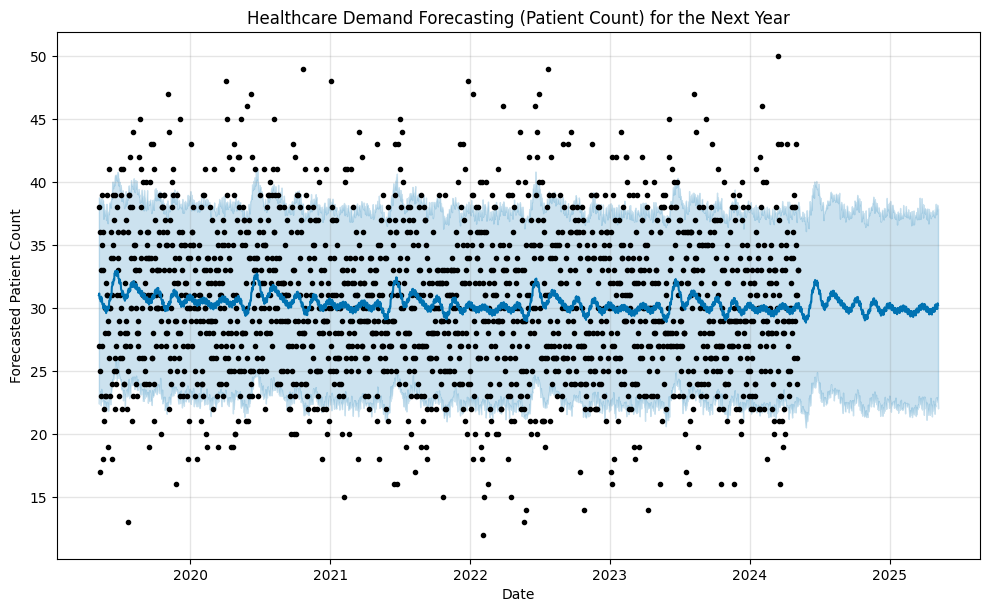

In [23]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title("Healthcare Demand Forecasting (Patient Count) for the Next Year")
plt.xlabel("Date")
plt.ylabel("Forecasted Patient Count")
plt.show()

C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

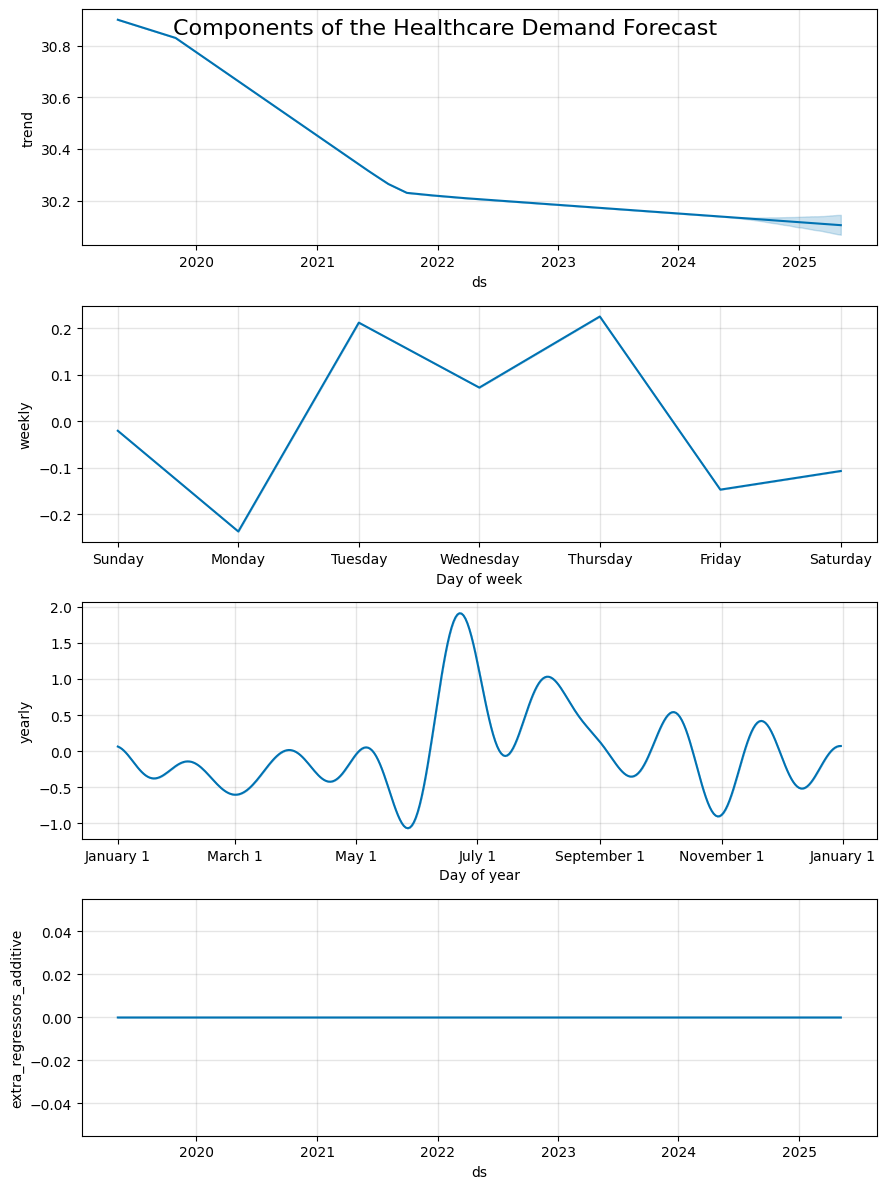

In [24]:
# Plot the components (seasonality, trend)
fig2 = model.plot_components(forecast)
plt.suptitle("Components of the Healthcare Demand Forecast", fontsize=16)
plt.show()

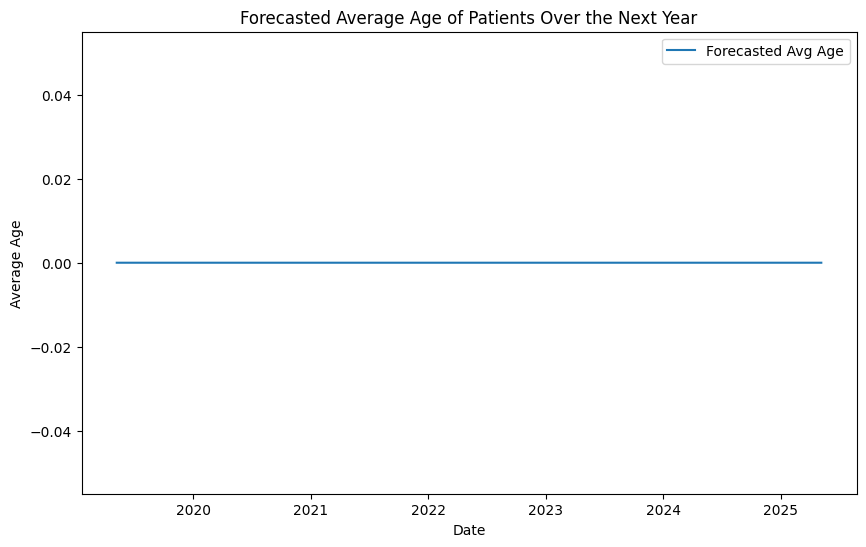

In [25]:
# Plotting forecast for 'avg_age' for visual relevance
fig3, ax = plt.subplots(figsize=(10, 6))
ax.plot(forecast['ds'], forecast['avg_age'], label='Forecasted Avg Age')
ax.set_title('Forecasted Average Age of Patients Over the Next Year')
ax.set_xlabel('Date')
ax.set_ylabel('Average Age')
ax.legend()
plt.show()